In [1]:
#For the update file, see http://www.envirofluidgroup.it/it/ricerca/164-bars.html
from sympy import *
from scipy import *
import scipy.integrate as integrate
from scipy.special import *
from numpy import linspace
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from mpmath import *
mp.dps = 15; mp.pretty = True

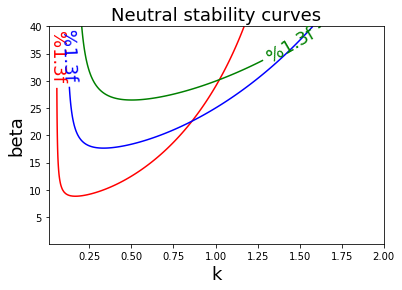

In [2]:
#Initial condition for the river bed (1 flat, 2 dune covered)
j=2;
#Suspended load (1 with suspension, 2 no suspension)
l=1;
#Definition of the base state
theta0=0.94;
ds=12*10**(-4);
Rp=13;


#Symbolic parameters
m, beta, k = symbols("m beta k");
#Transversal mode (m=1 is the alternate bar mode)
kn=m*pi/2; 
pd=(-1)**m;

#Hydrodynamic and sediment parameters
nu=10**(-6);#kinematic viscosity 
rhow=1000;#water density
mu=nu*rhow;
thetac=0.06;#critical Shields number
rhos=2650;#sediment density
Delta=(rhos-rhow)/rhow;
lambdap=0.3;#porosity
g=9.81;
r=0.56;#lateral slope effect

#Friction coefficient
if j==1:
    #flat condition
    Cf0=1/(3.71+2.5*log(1/ds))**(2); 
    Cd=-2/(1.484+log(1/ds));
    Ct=0;
elif j==2:
        #dune covered
        Cf0=theta0/((0.06+0.4*theta0**2)*(6+2.5*log((0.024+0.16*theta0**2)/(ds*theta0)))**2);
        Cd=-2/(0.567+log((0.15+theta0**2)/(ds*theta0)));
        Ct=(0.66-4.4*theta0**2+(0.15-theta0**2)*log((0.024+0.16*theta0**2)/(ds*theta0)))/((0.15+theta0**2)*(0.567+log((0.15+theta0**2)/(ds*theta0))));
else:
    print("error in the inital bed configuration");
s1=2/(1-Ct);
s2=Cd/(1-Ct);
    
#derived parameters
d50=(Rp*nu/(g*Delta)**(1/2))**(2/3);#sediment particle diameter
d0=d50/ds;#uniform water depth
J=theta0*Delta*ds;#slope
Fr=(J/Cf0)**(1/2); U0=Fr*(g*d0)**(1/2); 
Qs0=(Delta*g*d50**3)**(1/2);
gamma=Qs0/((1-lambdap)*U0*d0);
rtheta0=theta0**(1/2);

#Settling velocity
P=33.9; Q=0.98; m1=1.33; Da=d50*((Delta*g)/(nu**2))**(1/3);
vs=(P/Q)*(nu/d50)*((1/4+(4*Q*Da**3/(3*P**2))**(1/m1))**(1/2)-1/2)**m1;

#asymptotic parameter
delta=U0/(vs*beta);

#Effective roughness and effective Shield stress
if j==1:
    #flat condition
    thetap=theta0;
    epsilon=3*d50;
elif j==2:
        #dune covered 
        thetap=(0.06+0.4*theta0**2);
        lambdad=7.3*d0;#dune length
        etad=0.11*d0*ds**0.3*(1-exp(-0.5*(thetap-thetac)/thetac))*(25-(thetap-thetac)/thetac);#dune height
        epsilon=3*d50+etad*1.1*(1-exp(-25*etad/lambdad));
else:
    print("error in the inital bed configuration");
    
#Bedload
phi0=8*(thetap-0.047)**(3/2); 
phit=1.5*thetap/(thetap-0.047);
phid=0;
    
#Reference level a
if epsilon>0.01*d0:
    a=epsilon;
else:
        a=0.01*d0;
zetar=a/d0;#dimensionless reference level
if j==1:
    zeta0=zetar;
else:
        zeta0=3*d50;
#Concentration at the reference level a
Ce=0.015*(d50/a)*((thetap-thetac)/thetac)**(3/2)*Rp**(-0.2);

#parameters for the concentration
tau0=rhow*Cf0*U0**2;
ustar=(tau0/rhow)**0.5;
kc=0.4;#Von Karman constant
Z=vs/(kc*ustar);#Rouse number

#integrals for the depth-averaged concentration
I1=integrate.quad(lambda Zeta:((1-Zeta)*zetar/((1-zetar)*Zeta))**Z,zetar,1)[0];
I2=integrate.quad(lambda Zeta:(log(Zeta)+1.84*Zeta**2-1.56*Zeta**3)*((1-Zeta)*zetar/((1-zetar)*Zeta))**Z,zetar,1)[0];
I11=integrate.quad(lambda Zeta:log(((1-Zeta)*zetar/((1-zetar)*Zeta)))*((1-Zeta)*zetar/((1-zetar)*Zeta))**Z,zetar,1)[0];
I21=integrate.quad(lambda Zeta:(log(Zeta)+1.84*Zeta**2-1.56*Zeta**3)*log(((1-Zeta)*zetar/((1-zetar)*Zeta)))*((1-Zeta)*zetar/((1-zetar)*Zeta))**Z,zetar,1)[0];
I20=I2; I10=I1;

#depth averaged concentration
C0=(1/(1-zetar))*Ce*I1;

#Analytical expression for C12
A=1.84; B=-1.56;
Binc1=integrate.quad(lambda t: t**(1-Z-1)*(1-t)**(1+Z-1),0,zetar)[0] #incomplete beta function
def C12(Zeta):
        return (1/720)*Cf0**(1/2)*kc**(-1)*Z**(-1)*((-1)+zetar)*(2*(Zeta**(-1))\
**((-2)+Z)*((-1)*Binc1+pi*Z*(sin(pi*Z)**(-1)))**(-1)\
*(360*(((-2)+Z)**(-2)*hyp3f2(2-Z,2-Z,-Z,3-Z,3-Z,Zeta)+(-1)*((-3)+Z)**(-2)*Zeta*\
hyp3f2(3-Z,3-Z,-Z,4-Z,4-Z,Zeta))+(1+Z)*Zeta**((-2)+Z)*(integrate.quad(lambda t: t**(2-Z-1)*(1-t)**(1+Z-1),0,Zeta)[0])*(((-6)*A+B*(\
(-4)+Z))*((-3)+Z)*((-2)+Z)+(-120)*log(Zeta*zeta0**(-1)))+(1+(-1)*Zeta)\
**(1+Z)*(((-6)*A+B*((-4)+Z))*((-3)+Z)*(1+Z)+3*(6*A+(-1)*\
B*((-4)+Z))*(1+Z)*Zeta+12*((-6)*A+B+B*Z)*Zeta**2+(-60)*B*Zeta**3+( \
-120)*log(Zeta*zeta0**(-1))))+(-4)*(1+(-1)*Zeta)**Z*Zeta**((-1)*Z)*( \
Binc1+(-1)*pi*Z*(sin(pi*Z)**(-1)))**(-1)*((-1)*( \
Zeta**(-1))**Z*Zeta**(2+Z)*(45+Zeta*((-20)+9*A*Zeta*((-5)+4*Zeta)+6*B* \
Zeta**2*((-6)+5*Zeta))+30*((-3)+2*Zeta)*log(Zeta*zeta0**(-1)))+zetar**2*(45+ \
zetar*((-20)+9*A*zetar*((-5)+4*zetar)+6*B*zetar**2*((-6)+5*zetar))+30*( \
(-3)+2*zetar)*log(zeta0**(-1)*zetar)))+pi*Z*((-1)+Z**2)*(220+(-36)* \
A+(-24)*B+30*A*Z+26*B*Z+(-6)*A*Z**2+(-9)*B*Z**2+B*Z**3+(\
-120)*(polygamma(0,1-Z+1)+0.577)+(-120)*log(zeta0**(-1)))*(pi*Z+( \
-1)*Binc1*sin(pi*Z))**(-1));
    
A12=integrate.quad(lambda Zeta: C12(Zeta)*(log(Zeta)+A*Zeta**2+B*Zeta**3),zetar,1)[0];
A12a=integrate.quad(lambda Zeta: C12(Zeta),zetar,1)[0];

#K
K2=0.777+kc/Cf0**0.5;
K3=A12-log(zeta0)*A12a;
K1=Cf0**(0.5)*K3/kc;
K0=Cf0**(0.5)*(1-zetar)*(I2+K2*I1)/(kc*I1);
K10=K1; K20=K2; 
Kn=K10*Ce/((1-zetar)*(1-lambdap));

if l==1:
    #suspended load
    psi00=C0*K0/(1-lambdap);
    t1=s1*(Ct/2+1.5*thetap/(thetap-thetac)-0.5*((Z*(I21+K20*I11)+Ct*(I10*kc/(Cf0**0.5)))/(I20+K20*I10)));
    t2=-1+s2*(1/2+1.5*thetap/(thetap-thetac)-0.5*((Z*(I21+K20*I11)+(I10*kc/(Cf0**0.5)))/(I20+K20*I10)));
    t3=I10*(1.5*thetap/(thetap-thetac))*s1-0.5*Z*I11*s1;
    t4=I10*(1.5*s2*thetap/(thetap-thetac)-1)-0.5*Z*I11*s2;
elif l==2:
        #only bedload
        t1=0; t2=0; t3=0; t4=0; psi00=0;
else:
     print("error in the parameter for sediment load");

#Linear eigenvalue
Omega=(sqrt(-1)*Fr**(-2)*k*kn**2*pd**2+(-2)*Cf0*((-1)+Ct)**(-1)*\
Fr**(-2)*kn**2*pd**2*beta+(sqrt(-1)*(-1))*Fr**(-2)*((-1)+Fr**2)\
*k**2*(k+(sqrt(-1)*(-1))*Cf0*beta)+(-1)*Cf0*((-1)+Ct)**(-1)*((\
-3)+Cd+Ct)*k*beta*(k+(sqrt(-1)*(-1))*Cf0*beta))**(-1)*(((-1)+Ct)\
**(-1)*Fr**(-2)*k**2*Kn*(sqrt(-1)*((-1)+Ct)*k*(k**2*(t3+(\
-1)*t4)+(-1)*kn**2*pd**2*t4)+Cf0*(((-1)+Ct)*k**2*(t3+(-1)*\
t4)+kn**2*pd**2*((1+(-1)*Cd+(-1)*Ct)*t3+2*t4))*beta)*delta+sqrt(\
-1)*Fr**(-2)*((-1)+Fr**2)*k**3*kn**2*pd**2*gamma*r*rtheta0**(-1)\
*beta**(-1)*phi0+(sqrt(-1)*(-1))*Cf0**2*((-1)+Ct)**(-1)*((-3)+Cd+\
Ct)*k*kn**2*pd**2*gamma*r*rtheta0**(-1)*beta*phi0+((-1)+Ct)**(-1)*\
Fr**(-2)*kn**4*pd**4*gamma*r*rtheta0**(-1)*beta**(-1)*((sqrt(-1)*(-1)\
)*((-1)+Ct)*k+2*Cf0*beta)*phi0+((-1)+Ct)**(-1)*Fr**(-2)*k**3*(\
k+(sqrt(-1)*(-1))*Cf0*beta)*(gamma*phi0*(phid+(-1)*Ct*phid+((-2)+Cd)*\
phit)+((-1)+Ct)*(t1+(-1)*t2)*psi00)+((-1)+Ct)**(-1)*Fr**(-2)*\
k**2*kn**2*pd**2*rtheta0**(-1)*(Cf0*(1+(-1)*Ct+((-4)+Cd+2*Ct)*\
Fr**2)*gamma*r*phi0+gamma*rtheta0*phi0*((-1)+Ct+phid+(-1)*Ct*phid+Cd*phit)+(\
-1)*((-1)+Ct)*rtheta0*t2*psi00)+(sqrt(-1)*(-1))*Cf0*((-1)+Ct)**(\
-1)*Fr**(-2)*k*kn**2*pd**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+2*\
phit)+((1+(-1)*Cd+(-1)*Ct)*t1+2*t2)*psi00));

#Landau coefficient
Xi=(-128/9)*((-1)+Ct)**(-1)*Fr**(-2)*k**2*((-16)*((-1)+Ct)*((\
-1)+Fr**2)*k**3+(sqrt(-1)*8)*Cf0*(1+((-4)+Cd)*Fr**2+Ct*((-1)+ \
2*Fr**2))*k**2*beta+sqrt(-1)*Cf0*pi**2*beta+k*(((-1)+Ct)*pi**2+\
4*Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))**(-2)*((-4)*((-1)+Ct)*(( \
-1)+Fr**2)*k**3+(sqrt(-1)*(-4))*Cf0*(1+((-4)+Cd)*Fr**2+Ct*((\
-1)+2*Fr**2))*k**2*beta+(sqrt(-1)*(-2))*Cf0*pi**2*beta+k*(((-1)+\
Ct)*pi**2+4*Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))**(-1)*((-4)*(( \
-1)+Ct)*((-1)+Fr**2)*k**3+(sqrt(-1)*4)*Cf0*(1+((-4)+Cd)*\
Fr**2+Ct*((-1)+2*Fr**2))*k**2*beta+(sqrt(-1)*2)*Cf0*pi**2*beta+\
k*(((-1)+Ct)*pi**2+4*Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))**(-3)\
*(2*(((-1)+Ct)*k*((-4)*((-1)+Fr**2)*k**2+pi**2)+(sqrt(-1)*2)\
*Cf0*(2*(1+(-1)*Ct+((-4)+Cd+2*Ct)*Fr**2)*k**2+pi**2)*beta+4* \
Cf0**2*((-3)+Cd+Ct)*Fr**2*k*beta**2)**(-1)*(4*((-1)+Ct)**(-1)* \
Fr**(-2)*k**2*Kn*(sqrt(-1)*((-1)+Ct)*k*(4*k**2*(t3+(-1)*\
t4)+(-1)*pi**2*t4)+Cf0*(4*((-1)+Ct)*k**2*(t3+(-1)*t4)+ \
pi**2*((1+(-1)*Cd+(-1)*Ct)*t3+2*t4))*beta)*delta+(sqrt(-1)*4)* \
Fr**(-2)*((-1)+Fr**2)*k**3*pi**2*gamma*r*rtheta0**(-1)*beta**(-1)* \
phi0+(sqrt(-1)*(-4))*Cf0**2*((-1)+Ct)**(-1)*((-3)+Cd+Ct)*k*\
pi**2*gamma*r*rtheta0**(-1)*beta*phi0+((-1)+Ct)**(-1)*Fr**(-2)*pi**4* \
gamma*r*rtheta0**(-1)*beta**(-1)*((sqrt(-1)*(-1))*((-1)+Ct)*k+2*Cf0* \
beta)*phi0+16*((-1)+Ct)**(-1)*Fr**(-2)*k**3*(k+(sqrt(-1)*(-1))* \
Cf0*beta)*(gamma*phi0*(phid+(-1)*Ct*phid+((-2)+Cd)*phit)+((-1)+Ct)*(t1+( \
-1)*t2)*psi00)+4*((-1)+Ct)**(-1)*Fr**(-2)*k**2*pi**2*rtheta0**( \
-1)*(Cf0*(1+(-1)*Ct+((-4)+Cd+2*Ct)*Fr**2)*gamma*r*phi0+gamma*\
rtheta0*phi0*((-1)+Ct+phid+(-1)*Ct*phid+Cd*phit)+(-1)*((-1)+Ct)*rtheta0*\
t2*psi00)+(sqrt(-1)*(-4))*Cf0*((-1)+Ct)**(-1)*Fr**(-2)*k*\
pi**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+2*phit)+((1+(-1)*Cd+(-1)*Ct) \
*t1+2*t2)*psi00))+(-1)*(2*((-1)+Ct)*k*((-16)*((-1)+Fr**2)* \
k**2+pi**2)+(sqrt(-1)*2)*Cf0*(8*(1+(-1)*Ct+((-4)+Cd+2*Ct)*\
Fr**2)*k**2+pi**2)*beta+8*Cf0**2*((-3)+Cd+Ct)*Fr**2*k*beta**2)**( \
-1)*(16*((-1)+Ct)**(-1)*Fr**(-2)*k**2*Kn*((sqrt(-1)*2)*((\
-1)+Ct)*k*(16*k**2*(t3+(-1)*t4)+(-1)*pi**2*t4)+Cf0*(16*((\
-1)+Ct)*k**2*(t3+(-1)*t4)+pi**2*((1+(-1)*Cd+(-1)*Ct)*t3+2*\
t4))*beta)*delta+(sqrt(-1)*32)*Fr**(-2)*((-1)+Fr**2)*k**3*pi**2*\
gamma*r*rtheta0**(-1)*beta**(-1)*phi0+(sqrt(-1)*(-8))*Cf0**2*((-1)+Ct)\
**(-1)*((-3)+Cd+Ct)*k*pi**2*gamma*r*rtheta0**(-1)*beta*phi0+((-1)+Ct)\
**(-1)*Fr**(-2)*pi**4*gamma*r*rtheta0**(-1)*beta**(-1)*((sqrt(-1)*(\
-2))*((-1)+Ct)*k+2*Cf0*beta)*phi0+128*((-1)+Ct)**(-1)*Fr**(-2)*\
k**3*(2*k+(sqrt(-1)*(-1))*Cf0*beta)*(gamma*phi0*(phid+(-1)*Ct*phid+((\
-2)+Cd)*phit)+((-1)+Ct)*(t1+(-1)*t2)*psi00)+16*((-1)+Ct)**(-1)*\
Fr**(-2)*k**2*pi**2*rtheta0**(-1)*(Cf0*(1+(-1)*Ct+((-4)+Cd+2*\
Ct)*Fr**2)*gamma*r*phi0+gamma*rtheta0*phi0*((-1)+Ct+phid+(-1)*Ct*phid+Cd*\
phit)+(-1)*((-1)+Ct)*rtheta0*t2*psi00)+(sqrt(-1)*(-8))*Cf0*((-1)+Ct)\
**(-1)*Fr**(-2)*k*pi**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+2*phit)+(\
(1+(-1)*Cd+(-1)*Ct)*t1+2*t2)*psi00)))**(-1)*(2*(128*Cf0*((\
-1)+Ct)*(4+(-3)*Cd+2*Ct)*k**6*beta+(sqrt(-1)*4)*Cf0**2*((-22)+\
7*Cd**2+Cd*(7+(-14)*Ct)+31*Ct+(-23)*Ct**2)*k**3*pi**2*\
beta**2+(sqrt(-1)*(-1))*Cf0**2*((-4)+Ct)*((-1)+Cd+Ct)*k*pi**4*\
beta**2+Cf0**3*((-1)+3*Cd**2+(-2)*Ct+3*Ct**2+Cd*((-2)+6*Ct))*\
pi**4*beta**3+Cf0*k**2*pi**2*beta*(3*((-1)+Ct)*((-1)+Cd+Ct)*\
pi**2+4*Cf0**2*((-28)+3*Cd**2+Cd*(17+(-14)*Ct)+27*Ct+(-17)*\
Ct**2)*beta**2)+(sqrt(-1)*(-16))*((-1)+Ct)*k**5*(((-1)+Ct)*\
pi**2+4*Cf0**2*(3*Cd+(-2)*(2+Ct))*beta**2)+(-8)*Cf0*((-1)+Ct)\
*k**4*beta*(((-1)+5*Cd+6*Ct)*pi**2+8*Cf0**2*(3*Cd+(-2)*(2+\
Ct))*beta**2))*((sqrt(-1)*(-1))*((-1)+Ct)*k**2*Kn*(t3+(-1)*\
Fr**2*t4)*delta+sqrt(-1)*Cf0*Fr**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+\
2*phit)+((1+(-1)*Cd+(-1)*Ct)*t1+2*t2)*psi00)+k*(Cf0*Fr**2*\
Kn*(((-1)+Cd+Ct)*t3+(-2)*t4)*beta*delta+gamma*phi0*((-1)+Ct*(1+Fr**2*\
((-1)+phid))+2*phit+(-1)*Fr**2*((-1)+phid+Cd*phit))+(-1)*((-1)+Ct)*(\
t1+(-1)*Fr**2*t2)*psi00))+(-1)*(16*Cf0*((-2)+Cd)*((-1)+Ct)* \
k**4*beta+sqrt(-1)*Cf0**2*(43+8*Cd**2+(-30)*Ct+3*Ct**2+Cd*(( \
-35)+11*Ct))*k*pi**2*beta**2+(-1)*Cf0**3*(3+Cd**2+2*Cd*((-2)+ \
Ct)+(-4)*Ct+Ct**2)*pi**2*beta**3+2*Cf0*k**2*beta*((1+(-1)*Ct)*( \
(-7)+3*Cd+3*Ct)*pi**2+4*Cf0**2*((-2)+Cd)*((-3)+Cd+Ct)*beta**2) \
+(sqrt(-1)*8)*k**3*(((-1)+Ct)**2*pi**2+Cf0**2*((-2)+Cd)*((\
-11)+5*Cd+Ct)*beta**2))*((sqrt(-1)*(-4))*((-1)+Ct)*k**4*Kn*( \
t3+(-1)*Fr**2*t4)*delta+(sqrt(-1)*(-2))*Cf0*pi**2*beta*(gamma*phi0+ \
psi00)+k*((1+(-1)*Ct)*pi**2*(gamma*phi0+psi00)+(-4)*Cf0**2*Fr**2* \
beta**2*((-2)*gamma*phi0*(phid+phit)+((-3)+Cd+Ct+(-1)*t1+Cd*t1+Ct*t1+( \
-2)*t2)*psi00))+4*k**3*(Cf0*Kn*((1+((-1)+Cd)*Fr**2+Ct*((-1)+ \
Fr**2))*t3+((-3)+Ct)*Fr**2*t4)*beta*delta+2*gamma*phi0*phit+psi00+(-1)* \
Ct*psi00+t1*psi00+(-1)*Ct*t1*psi00+Fr**2*(gamma*phi0*(((-1)+Ct)*phid+( \
-1)*Cd*phit)+((-1)+Ct)*(1+t2)*psi00))+(sqrt(-1)*(-4))*Cf0*k**2* \
beta*(Cf0*Fr**2*Kn*(((-1)+Cd+Ct)*t3+(-2)*t4)*beta*delta+2*gamma*phi0* \
phit+psi00+(-1)*Ct*psi00+t1*psi00+(-1)*Ct*t1*psi00+Fr**2*(gamma*phi0*(((\
-3)+Ct)*phid+(-1)*(2+Cd)*phit)+((-4)+(-1)*t1+Cd*(1+t1)+(-3)*t2+\
Ct*(2+t1+t2))*psi00))))*((sqrt(-1)*(-1))*((-16)*Cf0*((-1)+Ct) \
*(4+(-3)*Cd+2*Ct)*k**6*beta+(sqrt(-1)*8)*Cf0**2*(Cd+Cd**2+(-2) \
*Cd*Ct+(-2)*((-1)+Ct+Ct**2))*k**3*pi**2*beta**2+(sqrt(-1)*(-2)) \
*Cf0**2*((-4)+Ct)*((-1)+Cd+Ct)*k*pi**4*beta**2+Cf0**3*((-1)+ \
3*Cd**2+(-2)*Ct+3*Ct**2+Cd*((-2)+6*Ct))*pi**4*beta**3+(sqrt(\
-1)*(-8))*((-1)+Ct)*k**5*(((-1)+Ct)*pi**2+4*Cf0**2*(3*Cd+(\
-2)*(2+Ct))*beta**2)+(-4)*Cf0*((-1)+Ct)*k**4*beta*(((-5)+(-2)* \
Cd+3*Ct)*pi**2+4*Cf0**2*(3*Cd+(-2)*(2+Ct))*beta**2)+Cf0*\
k**2*pi**2*beta*(3*((-1)+Ct)*((-1)+Cd+Ct)*pi**2+4*Cf0**2*(5+\
3*Cd**2+(-5)*Ct**2+(-2)*Cd*(2+Ct))*beta**2))*((sqrt(-1)*(-4))* \
((-1)+Ct)*k**2*Kn*(t3+(-1)*Fr**2*t4)*delta+sqrt(-1)*Cf0*\
Fr**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+2*phit)+((1+(-1)*Cd+(-1)*Ct)\
*t1+2*t2)*psi00)+2*k*(Cf0*Fr**2*Kn*(((-1)+Cd+Ct)*t3+(-2)*\
t4)*beta*delta+gamma*phi0*((-1)+Ct*(1+Fr**2*((-1)+phid))+2*phit+(-1)* \
Fr**2*((-1)+phid+Cd*phit))+(-1)*((-1)+Ct)*(t1+(-1)*Fr**2*t2)*\
psi00))+(-1)*(((-1)+Ct)*k+(sqrt(-1)*(-1))*Cf0*((-3)+Cd+Ct)*beta)*\
((sqrt(-1)*(-4))*Cf0*((-2)+Cd)*k**3*beta+(sqrt(-1)*(-2))*Cf0*((\
-2)+Cd+Ct)*k*pi**2*beta+(-1)*Cf0**2*((-1)+Cd+Ct)*pi**2*beta**2+\
k**2*(((-1)+Ct)*pi**2+(-4)*Cf0**2*((-2)+Cd)*beta**2))*((sqrt(\
-1)*(-32))*((-1)+Ct)*k**4*Kn*(t3+(-1)*Fr**2*t4)*delta+(sqrt(-1)\
*(-1))*Cf0*pi**2*beta*(gamma*phi0+psi00)+k*((1+(-1)*Ct)*pi**2*(gamma*\
phi0+psi00)+(-4)*Cf0**2*Fr**2*beta**2*((-2)*gamma*phi0*(phid+phit)+((-3)+\
Cd+Ct+(-1)*t1+Cd*t1+Ct*t1+(-2)*t2)*psi00))+16*k**3*(Cf0*Kn*\
((1+((-1)+Cd)*Fr**2+Ct*((-1)+Fr**2))*t3+((-3)+Ct)*Fr**2*t4)*\
beta*delta+2*gamma*phi0*phit+psi00+(-1)*Ct*psi00+t1*psi00+(-1)*Ct*t1*psi00+ \
Fr**2*(gamma*phi0*(((-1)+Ct)*phid+(-1)*Cd*phit)+((-1)+Ct)*(1+t2)* \
psi00))+(sqrt(-1)*(-8))*Cf0*k**2*beta*(Cf0*Fr**2*Kn*(((-1)+Cd+ \
Ct)*t3+(-2)*t4)*beta*delta+2*gamma*phi0*phit+psi00+(-1)*Ct*psi00+t1*psi00+( \
-1)*Ct*t1*psi00+Fr**2*(gamma*phi0*(((-3)+Ct)*phid+(-1)*(2+Cd)*phit)+ \
((-4)+(-1)*t1+Cd*(1+t1)+(-3)*t2+Ct*(2+t1+t2))*psi00))))+(1/128) \
*pi**4*((-4)*((-1)+Ct)*((-1)+Fr**2)*k**3+(sqrt(-1)*2)*Cf0*(\
1+((-4)+Cd)*Fr**2+Ct*((-1)+2*Fr**2))*k**2*beta+sqrt(-1)*Cf0*\
pi**2*beta+k*(((-1)+Ct)*pi**2+Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))\
**(-1)*((-4)*((-1)+Ct)*((-1)+Fr**2)*k**3+(sqrt(-1)*(-4))*\
Cf0*(1+((-4)+Cd)*Fr**2+Ct*((-1)+2*Fr**2))*k**2*beta+(sqrt(-1)*( \
-2))*Cf0*pi**2*beta+k*(((-1)+Ct)*pi**2+4*Cf0**2*((-3)+Cd+Ct)* \
Fr**2*beta**2))**(-1)*(((sqrt(-1)*2)*Fr**(-2)*k*pi**2+(-2)*\
Cf0*((-1)+Ct)**(-1)*Fr**(-2)*pi**2*beta+(sqrt(-1)*(-4))*Fr**(-2) \
*((-1)+Fr**2)*k**2*(2*k+(sqrt(-1)*(-1))*Cf0*beta)+(sqrt(-1)*2) \
*Cf0*((-1)+Ct)**(-1)*((-3)+Cd+Ct)*k*beta*((sqrt(-1)*2)*k+Cf0* \
beta))**(-1)*(4*((-1)+Ct)**(-1)*Fr**(-2)*k**2*Kn*((sqrt(-1)*8) \
*((-1)+Ct)*k**3*(t3+(-1)*t4)+(sqrt(-1)*(-2))*((-1)+Ct)*k*\
pi**2*t4+4*Cf0*((-1)+Ct)*k**2*(t3+(-1)*t4)*beta+Cf0*pi**2*(( \
1+(-1)*Cd+(-1)*Ct)*t3+2*t4)*beta)*delta+(sqrt(-1)*8)*Fr**(-2)*(( \
-1)+Fr**2)*k**3*pi**2*gamma*r*rtheta0**(-1)*beta**(-1)*phi0+(sqrt(-1)*(\
-2))*Cf0**2*((-1)+Ct)**(-1)*((-3)+Cd+Ct)*k*pi**2*gamma*r*\
rtheta0**(-1)*beta*phi0+((-1)+Ct)**(-1)*Fr**(-2)*pi**4*gamma*r*rtheta0**(\
-1)*beta**(-1)*((sqrt(-1)*(-2))*((-1)+Ct)*k+2*Cf0*beta)*phi0+8*(( \
-1)+Ct)**(-1)*Fr**(-2)*k**3*(2*k+(sqrt(-1)*(-1))*Cf0*beta)*( \
gamma*phi0*(phid+(-1)*Ct*phid+((-2)+Cd)*phit)+((-1)+Ct)*(t1+(-1)*t2)* \
psi00)+4*((-1)+Ct)**(-1)*Fr**(-2)*k**2*pi**2*rtheta0**(-1)*(Cf0*( \
1+(-1)*Ct+((-4)+Cd+2*Ct)*Fr**2)*gamma*r*phi0+gamma*rtheta0*phi0*((-1)+ \
Ct+phid+(-1)*Ct*phid+Cd*phit)+(-1)*((-1)+Ct)*rtheta0*t2*psi00)+(sqrt( \
-1)*(-2))*Cf0*((-1)+Ct)**(-1)*Fr**(-2)*k*pi**2*beta*(gamma*phi0*( \
(-3)+Cd+Ct+2*phid+2*phit)+((1+(-1)*Cd+(-1)*Ct)*t1+2*t2)*psi00))+( \
sqrt(-1)*(1/2))*((-1)+Ct)*Fr**2*(((-1)+Ct)*k*((-4)*((-1)+ \
Fr**2)*k**2+pi**2)+(sqrt(-1)*2)*Cf0*(2*(1+(-1)*Ct+((-4)+Cd+ \
2*Ct)*Fr**2)*k**2+pi**2)*beta+4*Cf0**2*((-3)+Cd+Ct)*Fr**2*k* \
beta**2)**(-1)*(4*((-1)+Ct)**(-1)*Fr**(-2)*k**2*Kn*(sqrt(-1)*( \
(-1)+Ct)*k*(4*k**2*(t3+(-1)*t4)+(-1)*pi**2*t4)+Cf0*(4*((\
-1)+Ct)*k**2*(t3+(-1)*t4)+pi**2*((1+(-1)*Cd+(-1)*Ct)*t3+2* \
t4))*beta)*delta+(sqrt(-1)*4)*Fr**(-2)*((-1)+Fr**2)*k**3*pi**2* \
gamma*r*rtheta0**(-1)*beta**(-1)*phi0+(sqrt(-1)*(-4))*Cf0**2*((-1)+Ct) \
**(-1)*((-3)+Cd+Ct)*k*pi**2*gamma*r*rtheta0**(-1)*beta*phi0+((-1)+Ct) \
**(-1)*Fr**(-2)*pi**4*gamma*r*rtheta0**(-1)*beta**(-1)*((sqrt(-1)*( \
-1))*((-1)+Ct)*k+2*Cf0*beta)*phi0+16*((-1)+Ct)**(-1)*Fr**(-2)* \
k**3*(k+(sqrt(-1)*(-1))*Cf0*beta)*(gamma*phi0*(phid+(-1)*Ct*phid+((-2) \
+Cd)*phit)+((-1)+Ct)*(t1+(-1)*t2)*psi00)+4*((-1)+Ct)**(-1)*Fr**( \
-2)*k**2*pi**2*rtheta0**(-1)*(Cf0*(1+(-1)*Ct+((-4)+Cd+2*Ct)* \
Fr**2)*gamma*r*phi0+gamma*rtheta0*phi0*((-1)+Ct+phid+(-1)*Ct*phid+Cd*phit)+( \
-1)*((-1)+Ct)*rtheta0*t2*psi00)+(sqrt(-1)*(-4))*Cf0*((-1)+Ct)**( \
-1)*Fr**(-2)*k*pi**2*beta*(gamma*phi0*((-3)+Cd+Ct+2*phid+2*phit)+((1+ \
(-1)*Cd+(-1)*Ct)*t1+2*t2)*psi00)))**(-1)*((-8)*k**2*(((-1)+ \
Ct)*k+(sqrt(-1)*(-1))*Cf0*((-3)+Cd+Ct)*beta)*((sqrt(-1)*(-1))*( \
(-1)+Ct)*k*(4*k**2+pi**2)+2*Cf0*((-2)*((-1)+Ct)*k**2+pi**2)\
*beta)*(((-1)+Ct)*k*((-4)*((-1)+Fr**2)*k**2+pi**2)+(sqrt(-1)*2) \
*Cf0*(2*(1+(-1)*Ct+((-4)+Cd+2*Ct)*Fr**2)*k**2+pi**2)*beta+4* \
Cf0**2*((-3)+Cd+Ct)*Fr**2*k*beta**2)**(-2)*((-4)*((-1)+Ct)*(( \
-1)+Fr**2)*k**3+(sqrt(-1)*2)*Cf0*(1+((-4)+Cd)*Fr**2+Ct*((-1)+\
2*Fr**2))*k**2*beta+sqrt(-1)*Cf0*pi**2*beta+k*(((-1)+Ct)*pi**2+ \
Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))**(-1)*(pi**2*((sqrt(-1)*(-2) \
)*((-1)+Ct)*k*Kn*t3*delta+gamma*phi0*((-1)+Ct+2*phit)+(-1)*((-1)+Ct) \
*t1*psi00)+2*Fr**2*k*(2*k+(sqrt(-1)*(-1))*Cf0*beta)*((sqrt(-1) \
*2)*((-1)+Ct)*k*Kn*(t3+(-1)*t4)*delta+gamma*phi0*(phid+(-1)*Ct*phid+( \
(-2)+Cd)*phit)+((-1)+Ct)*(t1+(-1)*t2)*psi00))+sqrt(-1)*rtheta0**(-1) \
*beta**(-1)*((-4)*((-1)+Ct)*((-1)+Fr**2)*k**3+(sqrt(-1)*4)*\
Cf0*(1+((-4)+Cd)*Fr**2+Ct*((-1)+2*Fr**2))*k**2*beta+(sqrt(-1)* \
2)*Cf0*pi**2*beta+k*(((-1)+Ct)*pi**2+4*Cf0**2*((-3)+Cd+Ct)* \
Fr**2*beta**2))**(-2)*((sqrt(-1)*4)*Cf0**2*pi**4*gamma*r*beta**2* \
phi0*((-1)+2*phid+2*phit)+(sqrt(-1)*16)*((-1)+Ct)*((-1)+Fr**2)* \
k**6*gamma*r*phi0*((-2)+Cd+2*((-1)+Ct)*phid+4*phit+(-2)*Cd*phit)+( \
-16)*k**5*beta*(Cf0*(2+((-5)+Cd)*Fr**2+Ct*((-2)+3*Fr**2))* \
gamma*r*phi0*(2+(-2)*((-1)+Ct)*phid+(-4)*phit+Cd*((-1)+2*phit))+(-2) \
*((-1)+Ct)*rtheta0*(gamma*phi0*((-1)+Ct+(-1)*phid+Ct*phid+2*phit+(-1)* \
Cd*phit)+(-1)*((-1)+Ct)*((-1)+t1+(-1)*t2)*psi00))+4*k**3*beta*( \
4*Cf0**3*((-3)+Cd+Ct)*Fr**2*gamma*r*beta**2*phi0*(2+(-2)*((-1)+ \
Ct)*phid+(-4)*phit+Cd*((-1)+2*phit))+Cf0*pi**2*gamma*r*phi0*(Cd**2* \
Fr**2*(1+(-2)*phit)+2*((-2)+(-2)*(3+(-4)*Ct+Ct**2)*phid+((-1)+ \
Ct)*Fr**2*(1+2*((-3)+Ct)*phid+(-2)*phit)+4*phit)+2*Cd*(2+(-1)* \
Fr**2*(2+phid+(-4)*phit)+(-4)*phit+Ct*((-1)+Fr**2*(1+phid+(-2)*phit)+ \
2*phit)))+8*Cf0**2*((-3)+Cd+Ct)*rtheta0*beta**2*(gamma*phi0*(1+phid+(-1)* \
Ct*(1+phid)+(-2)*phit+Cd*phit)+((-1)+Ct)*((-1)+t1+(-1)*t2)*psi00)+ \
2*((-1)+Ct)*pi**2*rtheta0*(gamma*phi0*(((-1)+Ct)*phid+(-1)*Cd*phit)+(( \
-1)+Ct)*(1+t2)*psi00))+(sqrt(-1)*(-4))*k**4*(((-1)+Ct)*pi**2* \
gamma*r*phi0*((-2)+(-2)*((-1)+Ct)*((-2)+Fr**2)*phid+4*phit+Cd*((-2) \
+Fr**2)*((-1)+2*phit))+(-4)*Cf0*beta**2*(Cf0*(1+((-7)+2*Cd)* \
Fr**2+Ct*((-1)+3*Fr**2))*gamma*r*phi0*(2+(-2)*((-1)+Ct)*phid+(-4) \
*phit+Cd*((-1)+2*phit))+2*((-4)+Cd+2*Ct)*rtheta0*(gamma*phi0*(1+phid+( \
-1)*Ct*(1+phid)+(-2)*phit+Cd*phit)+((-1)+Ct)*((-1)+t1+(-1)*t2)* \
psi00)))+2*Cf0*k*pi**2*beta*(pi**2*gamma*r*phi0*(Cd+(-2)*Cd*phit+(( \
-1)+Ct)*((-1)+4*phid+2*phit))+4*Cf0*((-3)+Cd+Ct)*beta**2*(Cf0* \
Fr**2*gamma*r*phi0*((-1)+2*phid+2*phit)+rtheta0*(gamma*phi0*((-1)+Cd+Ct+2* \
phid+2*phit)+((1+(-1)*Cd+(-1)*Ct)*t1+2*(1+t2))*psi00)))+sqrt(-1)* \
k**2*pi**2*(4*Cf0*Cd**2*gamma*beta**2*phi0*(2*rtheta0*phit+Cf0* \
Fr**2*r*((-1)+2*phit))+(-2)*(((-1)+Ct)**2*pi**2*gamma*r*phi0*phid+ \
4*Cf0**2*gamma*r*beta**2*phi0*((-1)+(-4)*phid+Ct**2*Fr**2*phid+2*phit+ \
(-1)*Ct*((-1)+2*Fr**2)*((-1)+4*phid+2*phit)+Fr**2*((-4)+11*phid+ \
8*phit))+4*Cf0*((-1)+Ct)*rtheta0*beta**2*(gamma*phi0*(1+Ct*((-1)+phid)+( \
-5)*phid+(-2)*phit)+((-5)+(-1)*t1+(-5)*t2+Ct*(1+t1+t2))*psi00))+ \
Cd*(((-1)+Ct)*pi**2*gamma*r*phi0*((-1)+2*phit)+(-4)*Cf0*beta**2*( \
Cf0*gamma*r*phi0*(2+(-4)*phit+Fr**2*((-1)+Ct+(-6)*phid+2*Ct*phid+2* \
phit+(-2)*Ct*phit))+2*rtheta0*(gamma*phi0*(1+(-1)*phid+Ct*((-1)+phid+(-1)* \
phit)+3*phit)+((-1)+Ct)*(1+t1+t2)*psi00))))))*((sqrt(-1)*(-4))* \
k**2*(16*((-1)+Ct)**2*k**4+(sqrt(-1)*4)*Cf0*((-1)+Ct)*((-4)+\
Cd+2*Ct)*k**3*beta+sqrt(-1)*Cf0*((-1)+Ct)*((-5)+Cd+Ct)*k*\
pi**2*beta+(-4)*Cf0**2*((-3)+Cd+Ct)*pi**2*beta**2+4*((-1)+Ct)* \
k**2*(((-1)+Ct)*pi**2+2*Cf0**2*((-3)+Cd+Ct)*beta**2))*((-4)*(( \
-1)+Ct)*((-1)+Fr**2)*k**3+(sqrt(-1)*4)*Cf0*(1+((-4)+Cd)* \
Fr**2+Ct*((-1)+2*Fr**2))*k**2*beta+(sqrt(-1)*2)*Cf0*pi**2*beta+ \
k*(((-1)+Ct)*pi**2+4*Cf0**2*((-3)+Cd+Ct)*Fr**2*beta**2))**(-1) \
*(pi**2*((sqrt(-1)*(-1))*((-1)+Ct)*k*Kn*t3*delta+gamma*phi0*((-1)+ \
Ct+2*phit)+(-1)*((-1)+Ct)*t1*psi00)+4*Fr**2*k*(k+(sqrt(-1)*(-1) \
)*Cf0*beta)*(sqrt(-1)*((-1)+Ct)*k*Kn*(t3+(-1)*t4)*delta+gamma*phi0* \
(phid+(-1)*Ct*phid+((-2)+Cd)*phit)+((-1)+Ct)*(t1+(-1)*t2)*psi00))+( \
-1)*rtheta0**(-1)*beta**(-1)*(2*Cf0**2*pi**4*gamma*r*beta**2*phi0*((-1) \
+2*phid+2*phit)+(-16)*((-1)+Ct)*((-1)+Fr**2)*k**6*gamma*r*phi0*(( \
-2)+Cd+2*((-1)+Ct)*phid+4*phit+(-2)*Cd*phit)+(sqrt(-1)*(-8))* \
k**5*beta*((-1)*Cf0*((-1)+Ct+((-11)+4*Cd)*Fr**2+3*Ct*Fr**2)* \
gamma*r*phi0*((-2)+Cd+2*((-1)+Ct)*phid+4*phit+(-2)*Cd*phit)+(-8)*(( \
-1)+Ct)*rtheta0*(gamma*phi0*((-1)+Ct+(-1)*phid+Ct*phid+2*phit+(-1)*Cd* \
phit)+(-1)*((-1)+Ct)*((-1)+t1+(-1)*t2)*psi00))+(sqrt(-1)*(-2))* \
k**3*beta*(8*Cf0**3*((-3)+Cd+Ct)*Fr**2*gamma*r*beta**2*phi0*(2+(-2) \
*((-1)+Ct)*phid+(-4)*phit+Cd*((-1)+2*phit))+Cf0*pi**2*gamma*r*phi0* \
((-1)*Cd*(7+(-8)*Fr**2*(2+phid+(-4)*phit)+Ct*(1+8*Fr**2*(1+phid+ \
(-2)*phit)+(-2)*phit)+(-14)*phit)+4*Cd**2*Fr**2*((-1)+2*phit)+(-2) \
*((-8)+(3+(-4)*Ct+Ct**2)*phid+16*phit+((-1)+Ct)*Fr**2*((-5)+(( \
-6)+8*Ct)*phid+10*phit)))+16*Cf0**2*((-3)+Cd+Ct)*rtheta0*beta**2*( \
gamma*phi0*(1+phid+(-1)*Ct*(1+phid)+(-2)*phit+Cd*phit)+((-1)+Ct)*((-1)+ \
t1+(-1)*t2)*psi00)+(-8)*((-1)+Ct)*pi**2*rtheta0*(gamma*phi0*(((-1)+ \
Ct)*phid+(-1)*Cd*phit)+((-1)+Ct)*(1+t2)*psi00))+4*k**4*(((-1)+Ct) \
*pi**2*gamma*r*phi0*((-2)+(-2)*((-1)+Ct)*((-2)+Fr**2)*phid+4*phit+ \
Cd*((-2)+Fr**2)*((-1)+2*phit))+2*Cf0*beta**2*(Cf0*(1+((-7)+2* \
Cd)*Fr**2+Ct*((-1)+3*Fr**2))*gamma*r*phi0*(2+(-2)*((-1)+Ct)* \
phid+(-4)*phit+Cd*((-1)+2*phit))+2*((-4)+Cd+2*Ct)*rtheta0*(gamma*phi0*( \
1+phid+(-1)*Ct*(1+phid)+(-2)*phit+Cd*phit)+((-1)+Ct)*((-1)+t1+(-1)* \
t2)*psi00)))+(sqrt(-1)*(-1))*Cf0*k*pi**2*beta*(pi**2*gamma*r*phi0* \
(Cd*((-4)+8*phit)+((-1)+Ct)*((-5)+2*phid+10*phit))+8*Cf0*((-3)+\
Cd+Ct)*beta**2*(Cf0*Fr**2*gamma*r*phi0*((-1)+2*phid+2*phit)+rtheta0*( \
gamma*phi0*((-1)+Cd+Ct+2*phid+2*phit)+((1+(-1)*Cd+(-1)*Ct)*t1+2*(1+ \
t2))*psi00)))+(-1)*k**2*pi**2*(2*Cf0*Cd**2*gamma*beta**2*phi0*(\
Cf0*Fr**2*r*(1+(-2)*phit)+(-2)*rtheta0*phit)+2*((-1)*((-1)+Ct)\
**2*pi**2*gamma*r*phi0*phid+2*Cf0**2*gamma*r*beta**2*phi0*((-1)+(-4)*\
phid+Ct**2*Fr**2*phid+2*phit+(-1)*Ct*((-1)+2*Fr**2)*((-1)+4*phid+\
2*phit)+Fr**2*((-4)+11*phid+8*phit))+2*Cf0*((-1)+Ct)*rtheta0*beta**2*(\
gamma*phi0*(1+Ct*((-1)+phid)+(-5)*phid+(-2)*phit)+((-5)+(-1)*t1+(-5)*\
t2+Ct*(1+t1+t2))*psi00))+Cd*(((-1)+Ct)*pi**2*gamma*r*phi0*((-1)+\
2*phit)+2*Cf0*beta**2*(Cf0*gamma*r*phi0*(2+(-4)*phit+Fr**2*((-1)+Ct+\
(-6)*phid+2*Ct*phid+2*phit+(-2)*Ct*phit))+2*rtheta0*(gamma*phi0*(1+(-1)*\
phid+Ct*((-1)+phid+(-1)*phit)+3*phit)+((-1)+Ct)*(1+t1+t2)*psi00))))));

#Numerical results
kin=0.01; kfin=2; #limits for k
betain=0.1; betafin=40; #limits for k

OmegaN=lambdify([m,k,beta],Omega,"numpy");
XiN=lambdify([m,k,beta],Xi,"numpy");
num=200;
k_vec=linspace(kin,kfin,num);
beta_vec=linspace(betain,betafin,num);
Omega1r=np.zeros((num,num));
Omega2r=np.zeros((num,num));
Omega3r=np.zeros((num,num));
for i1 in range (0,num):
    for i2 in range (0,num):
             Omega1r[i2][i1]=(OmegaN(1,k_vec[i1],beta_vec[i2])).real;
             Omega2r[i2][i1]=(OmegaN(2,k_vec[i1],beta_vec[i2])).real;
             Omega3r[i2][i1]=(OmegaN(3,k_vec[i1],beta_vec[i2])).real;
            
#plot neutral stability curves
plt.show()
cs1=plt.contour(k_vec,beta_vec,Omega1r,0,colors='r')
fmt = {};
strs = [ 'm=1']
for p1,p2 in zip(cs1.levels, strs ):
    fmt[p1] = p2
plt.clabel(cs1,cs1.levels,inline=True,fmt=fmt,fontsize=18)

cs2=plt.contour(k_vec,beta_vec,Omega2r,0,colors='b')
fmt = {}
strs = [ 'm=2']
for p1,p2 in zip(cs2.levels, strs ):
    fmt[p1] = p2
plt.clabel(cs2,cs2.levels,inline=True,fmt=fmt,fontsize=18)

cs3=plt.contour(k_vec,beta_vec,Omega3r,0,colors='g')
fmt = {}
strs = [ 'm=3']
for p1,p2 in zip(cs3.levels, strs ):
    fmt[p1] = p2

plt.clabel(cs3,cs3.levels,inline=True,fmt=fmt,fontsize=18)

plt.title('Neutral stability curves',fontsize=18)
plt.xlabel('k',fontsize=18)
plt.ylabel('beta',fontsize=18);

#neglect the warning message on the integration, we have verified the convergence of the integral both with Mathematica and Matlab

In [4]:
#dimensional results for the alternate bars
#Restart the kernel after using this cell

#specify an aspect ratio
beta=20;

#find the fastest growing mode
Omega1r_beta=np.zeros(num);
for i1 in range (0,num):
    Omega1r_beta[i1]=(OmegaN(1,k_vec[i1],beta)).real;
    if i1>0:
        if Omega1r_beta[i1]>Omega1r_beta[i1-1]:
            k_s=k_vec[i1];

#uncomment the following for the growth rate vs k plot
#plt.plot(k_vec,Omega1r_beta)
#plt.title('Growth rate vs k',fontsize=18)
#plt.xlabel('k',fontsize=18)
#plt.ylabel('Omega1r',fontsize=18);

bar_wavelength=2*pi*d0*beta/k_s;
bar_height=4*d0*(-((OmegaN(1,k_s,beta)).real)/((XiN(1,k_s,beta)).real))**0.5;#from crest to trough

print('Bar wavelength=',"%.0f" %bar_wavelength,'m')
print('Bar height=',"%.2f" %bar_height,'m')

Bar wavelength= 69 m
Bar height= 0.26 m
